In [121]:
import torch
import matplotlib.pyplot as plt
from typing import Tuple, List
from sklearn.naive_bayes import GaussianNB

## 一、数据预处理

In [122]:
class DataProcess:
    def __init__(self, images_path: str, labels_path: str, nums: int) -> None:
        self.images_path = images_path
        self.labels_path = labels_path
        self.nums = nums
        self.images = None
        self.labels = None
        self.X = None
        self.y = None
        
        img_path = open(self.images_path, 'rb')
        try:
            # 跳过前面的magic number和图像个数、行列数
            img_path.read(16)
            images = torch.tensor(
                [int.from_bytes(img_path.read(1), byteorder='big') for _ in range(nums * 28 * 28)],
                dtype=torch.uint8)
            images = images.view(nums, 28, 28)
        finally:
            img_path.close()
        
        lb_path = open(self.labels_path, 'rb')
        try:
            # 跳过前面的magic number和标签个数
            lb_path.read(8)
            labels = torch.tensor(
                [int.from_bytes(lb_path.read(1), byteorder='big') for _ in range(nums)],
                dtype=torch.uint8)
        finally:
            lb_path.close()
        
        self.images, self.labels = images, labels
    
    
    def show_data(self, bin: bool = False, cnt: int = 5) -> None:
        fig, axs = plt.subplots(1, cnt, figsize=(10, 10))
        for i in range(cnt):
            if bin:
                axs[i].imshow(self.X[i].view(28, 28), cmap='gray')
            else:
                axs[i].imshow(self.images[i], cmap='gray')
            axs[i].set_title(f'Label: {self.y[i]}')
            axs[i].axis('off')
        plt.show()
    
    
    def reshape(self) -> None:
        # 矩阵展平
        self.X, self.y = self.images.view(self.images.shape[0], -1), self.labels
    
    
    def binary(self) -> None:
        # 二值化处理
        self.X = (self.X > 0).to(torch.uint8)
    
    
    def get_data(self) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.X, self.y

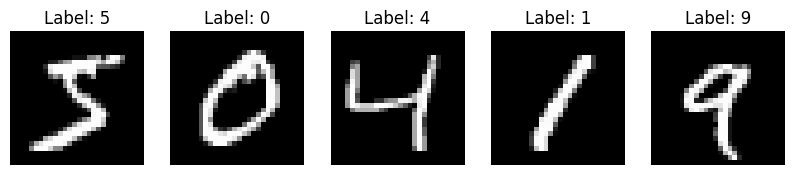

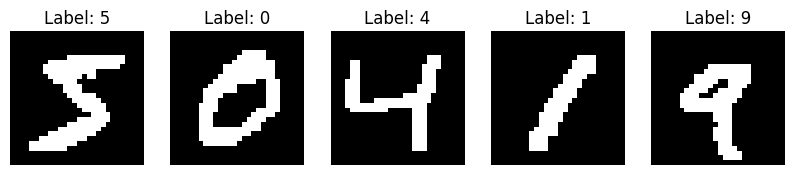

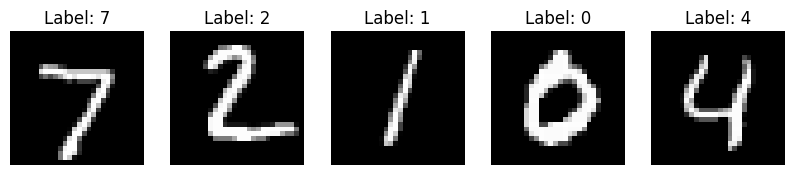

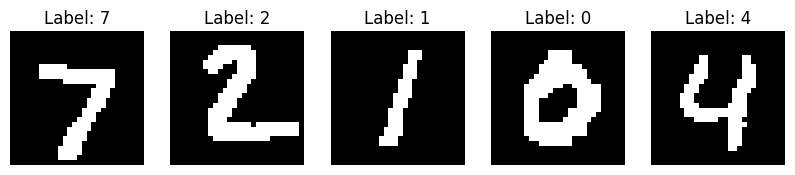

In [123]:
train_images_path = './dataset/train-images.idx3-ubyte'
train_labels_path = './dataset/train-labels.idx1-ubyte'
test_images_path = './dataset/t10k-images.idx3-ubyte'
test_labels_path = './dataset/t10k-labels.idx1-ubyte'

train = DataProcess(train_images_path, train_labels_path, 60000)
test = DataProcess(test_images_path, test_labels_path, 10000)
train.reshape()
test.reshape()

ori_train_X, train_y = train.get_data()
train.show_data(False, 5)
train.binary()
bin_train_X, train_y = train.get_data()
train.show_data(True, 5)

ori_test_X, test_y = test.get_data()
test.show_data(False, 5)
test.binary()
bin_test_X, test_y = test.get_data()
test.show_data(True, 5)

## 二、模型构建

In [124]:
class MyNaiveBayes:
    def __init__(self, opt: str = "log") -> None:
        self.opt = opt
        self.classes = None
        self.class_priors = None
        self.feature_probs = None
    
    
    def fit(self, train_X: torch.Tensor, train_y: torch.Tensor) -> None:
        # 计算类的先验概率
        self.classes, counts = train_y.unique(return_counts=True)
        self.class_priors = counts.float() / train_y.shape[0]
        
        # 初始化特征条件概率矩阵
        num_features = train_X.shape[1]
        num_classes = len(self.classes)
        self.feature_probs = torch.zeros((num_classes, num_features))
        
        # 计算特征条件概率
        for idx, cls in enumerate(self.classes):
            class_indices = (train_y == cls)
            class_features = train_X[class_indices]
            if self.opt == "log":
                # 使用连乘取对数
                self.feature_probs[idx, :] = (class_features.sum(dim=0) + 1) / (class_indices.sum() + 2)
            elif self.opt == "laplace":
                # 使用拉普拉斯平滑
                self.feature_probs[idx, :] = (class_features.sum(dim=0) + 1) / (class_indices.sum() + 2)
            else:
                # 不使用平滑
                self.feature_probs[idx, :] = class_features.sum(dim=0) / class_indices.sum()
    
    
    def predict(self, test_X: torch.Tensor) -> torch.Tensor:
        num_samples = test_X.shape[0]
        num_classes = len(self.classes)
        
        # 初始化后验概率矩阵
        log_posteriors = torch.zeros((num_samples, num_classes))
        
        for idx, cls in enumerate(self.classes):
            # 计算每个样本属于当前类的对数后验概率
            if self.opt == "log":
                # 计算 log P(x|y) + log P(y)
                log_likelihood = (test_X * torch.log(self.feature_probs[idx, :]) +
                                  (1 - test_X) * torch.log(1 - self.feature_probs[idx, :])).sum(dim=1)
                log_prior = torch.log(self.class_priors[idx])
                log_posteriors[:, idx] = log_likelihood + log_prior
            else:
                # 计算 P(x|y) + log P(y) 使用拉普拉斯平滑
                smoothed_feature_probs = (self.feature_probs[idx, :] + 1) / (self.feature_probs[idx, :].sum() + 2)
                log_likelihood = (test_X * torch.log(smoothed_feature_probs) +
                                  (1 - test_X) * torch.log(1 - smoothed_feature_probs)).sum(dim=1)
                log_prior = torch.log(self.class_priors[idx])
                log_posteriors[:, idx] = log_likelihood + log_prior
        
        # 返回具有最大后验概率的类
        return self.classes[log_posteriors.argmax(dim=1)]

## 三、模型测试与评估

In [125]:
### self library 原始数据 ###
ori_model = MyNaiveBayes(opt='log')
model.fit(ori_train_X, train_y)
ori_pred_y = model.predict(ori_test_X)
ori_accuracy = (ori_pred_y == test_y).sum() / test_y.shape[0]
print(f'Accuracy: {ori_accuracy:.4f}')

Accuracy: 0.0980


In [126]:
### self library 二值化数据 ###
bin_model = MyNaiveBayes(opt='log')
model.fit(bin_train_X, train_y)
bin_pred_y = model.predict(bin_test_X)
bin_accuracy = (bin_pred_y == test_y).sum() / test_y.shape[0]
print(f'Accuracy: {bin_accuracy:.4f}')

Accuracy: 0.8413


In [127]:
### std library ###
clf = GaussianNB()
clf.fit(ori_train_X, train_y)
std_pred_y = torch.tensor(clf.predict(ori_test_X))
std_accuracy = (std_pred_y == test_y).sum() / test_y.shape[0]
print(f'Accuracy: {std_accuracy:.4f}')

Accuracy: 0.5558


In [128]:
for x in range(10):
    print(f'Number {x} count: {torch.sum(test_y == x)}')

for x in range(10):
    print(f'Number {x} count: {torch.sum(pred_y == x)}')

for x in range(10):
    print(f'Number {x} count: {torch.sum(std_pred_y == x)}')

Number 0 count: 980
Number 1 count: 1135
Number 2 count: 1032
Number 3 count: 1010
Number 4 count: 982
Number 5 count: 892
Number 6 count: 958
Number 7 count: 1028
Number 8 count: 974
Number 9 count: 1009
Number 0 count: 980
Number 1 count: 1204
Number 2 count: 958
Number 3 count: 1105
Number 4 count: 963
Number 5 count: 763
Number 6 count: 958
Number 7 count: 940
Number 8 count: 1004
Number 9 count: 1125
Number 0 count: 1101
Number 1 count: 1276
Number 2 count: 294
Number 3 count: 498
Number 4 count: 190
Number 5 count: 80
Number 6 count: 1377
Number 7 count: 319
Number 8 count: 2280
Number 9 count: 2585
